# **LY PROJECT**
## **Sign Language Gesture Recognition Model**
**Mentor:** Deepti Patole <br>
**Group Members:** Mayank Pujara | Ishaan Gurnani | Harshit Shangvi

## **Installing Required Libraries**

In [1]:
!pip install split-folders
!pip install kaggle

##**Importing Necessary Libraries**

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import splitfolders
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

## **Setting up Kaggle API for Downloading the ASL Dataset**

---



In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mayankpujara","key":"60cdc937224bd1ecd52694857efe06b1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ayuraj/asl-dataset
!unzip asl-dataset.zip -d asl-dataset

Streaming output truncated to the last 5000 lines.
  inflating: asl-dataset/asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl-dataset/asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  

## **Data Preparation: Creating the DataFrame**

In [10]:
# Path where our data is located
base_path = "/content/asl-dataset/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)

## **Displaying the Sample Images and Class Distribution**

In [11]:
df

filename  category
0       4/hand1_4_bot_seg_3_cropped.jpeg         4
1     4/hand1_4_right_seg_4_cropped.jpeg         4
2       b/hand2_b_top_seg_4_cropped.jpeg        11
3     d/hand2_d_right_seg_5_cropped.jpeg        13
4       d/hand1_d_bot_seg_3_cropped.jpeg        13
...                                  ...       ...
2510    1/hand1_1_top_seg_5_cropped.jpeg         1
2511    6/hand3_6_dif_seg_1_cropped.jpeg         6
2512  o/hand2_o_right_seg_4_cropped.jpeg        24
2513    i/hand2_i_dif_seg_5_cropped.jpeg        18
2514    n/hand5_n_dif_seg_5_cropped.jpeg        23

[2515 rows x 2 columns]

In [12]:
print("Number of Elements: ", len(df))

Number of Elements:  2515


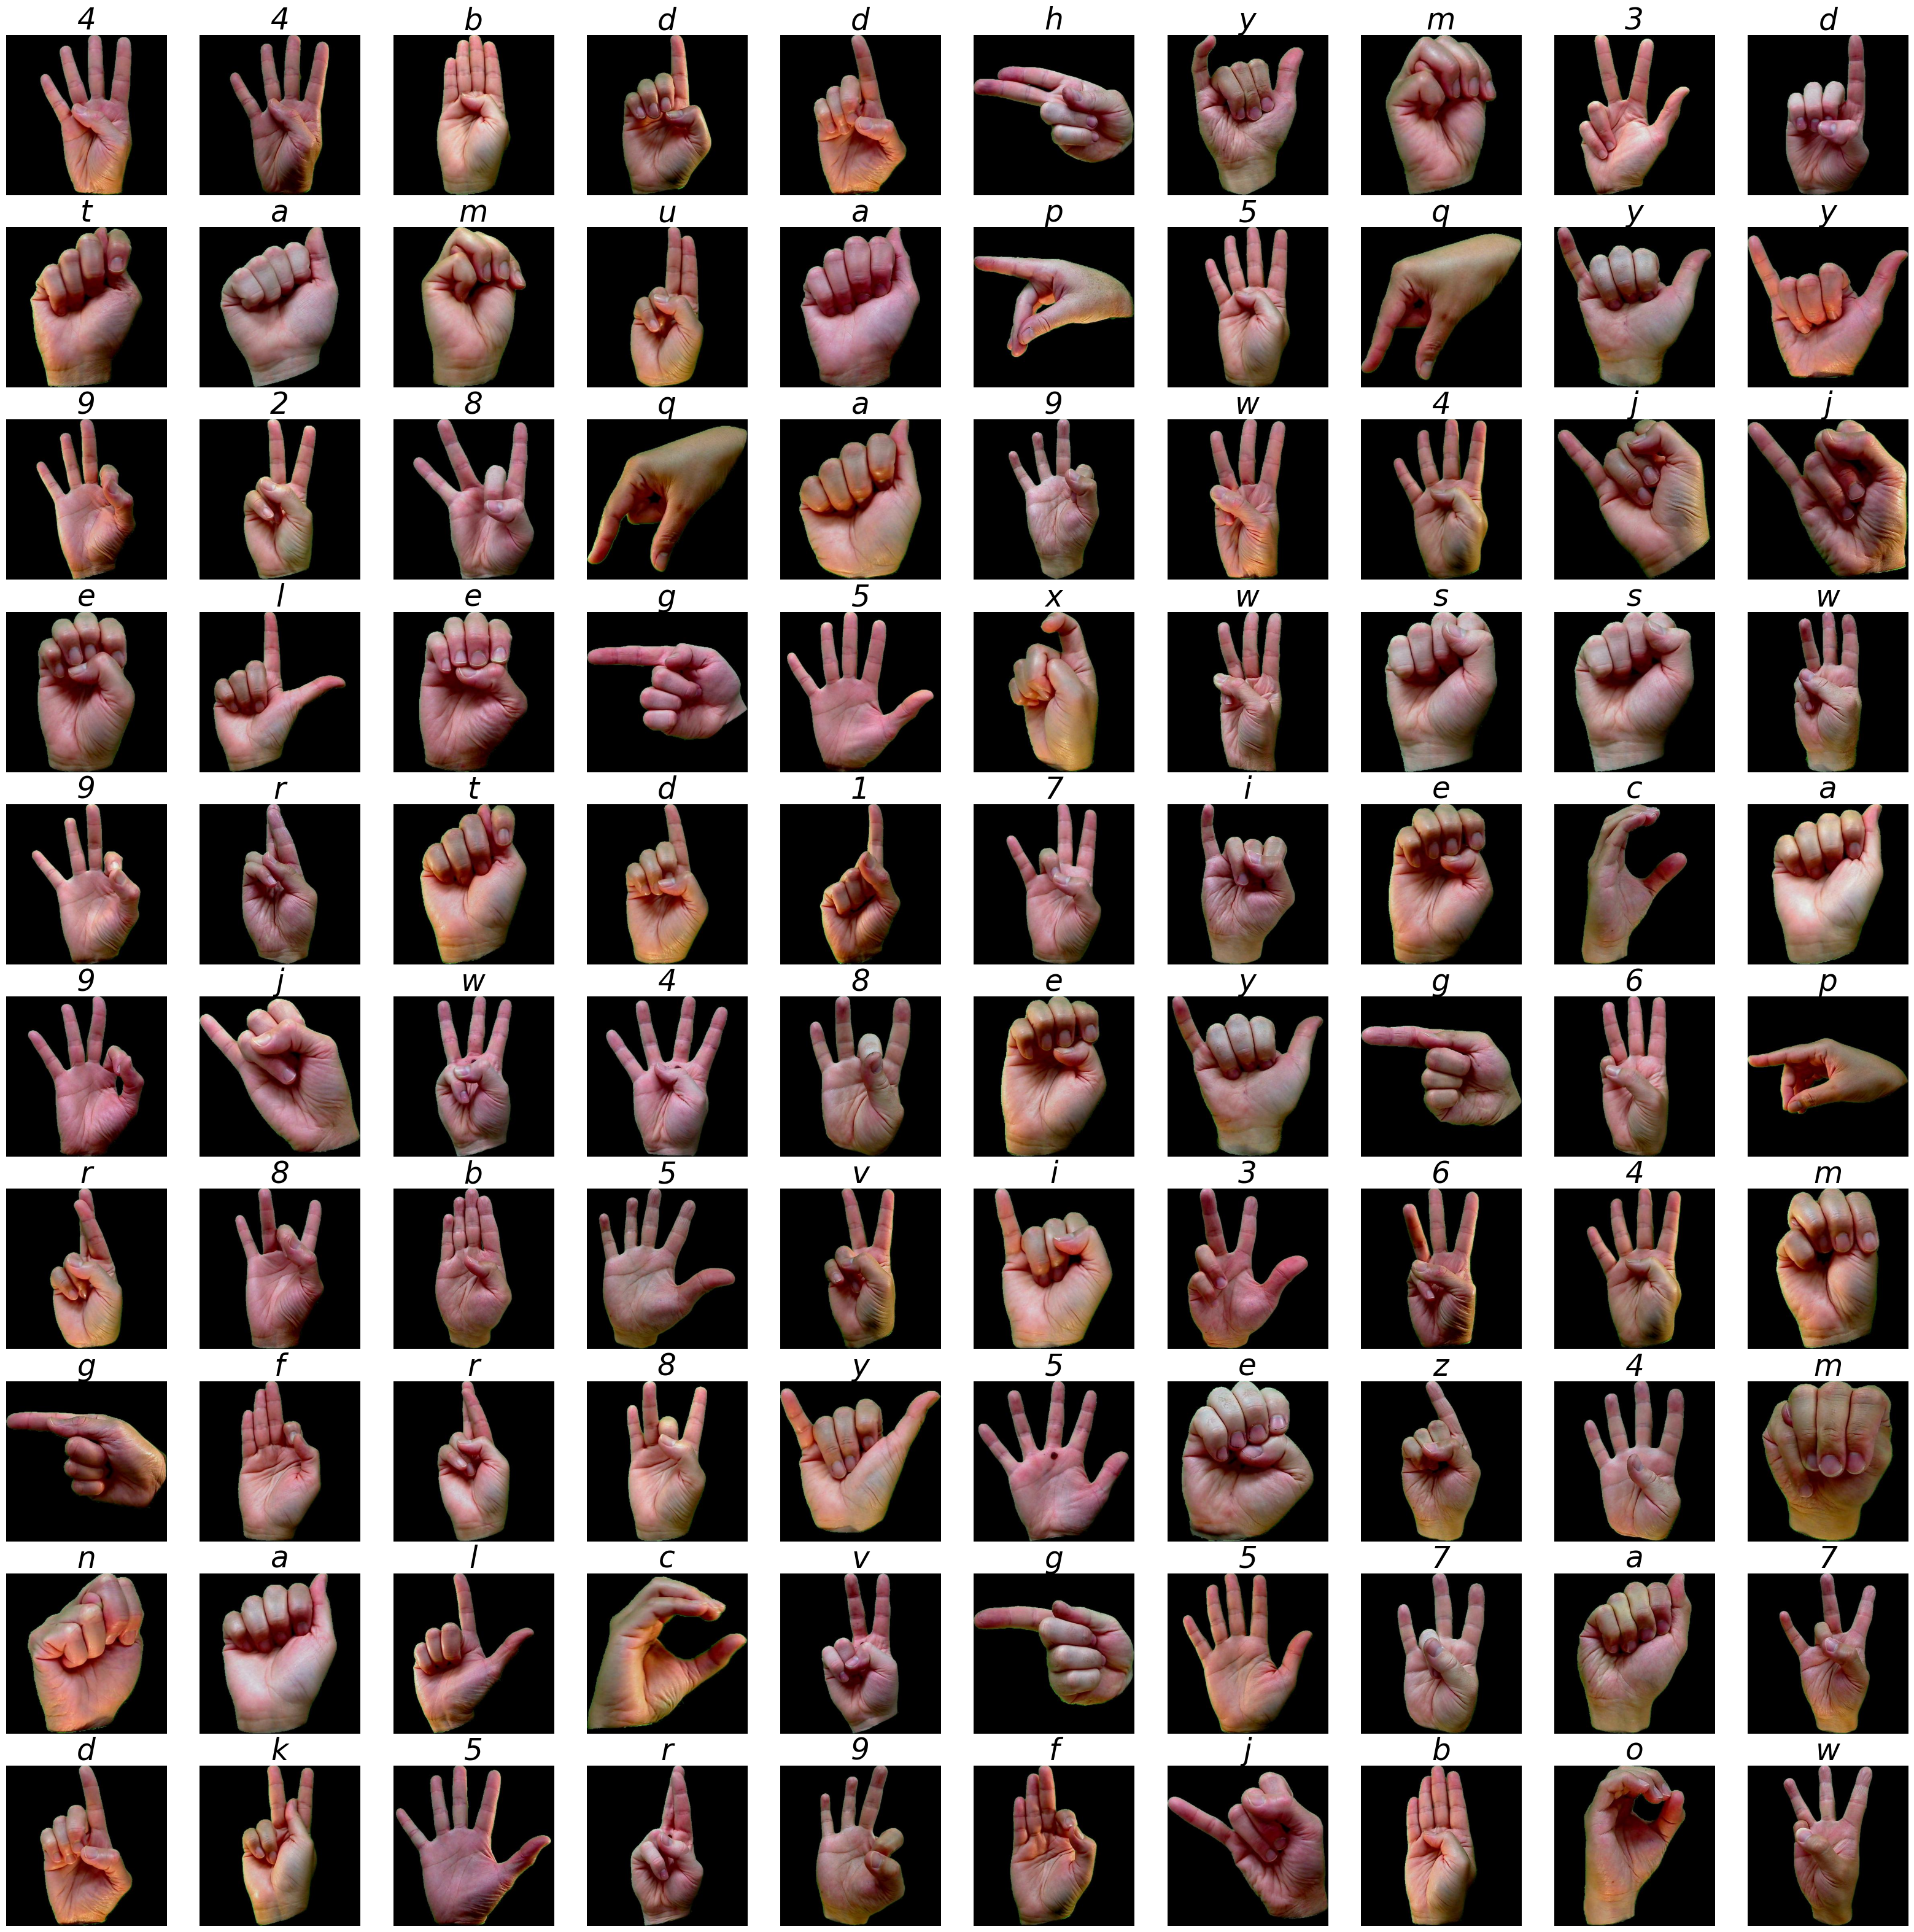

In [13]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = base_path + df.filename[i]
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

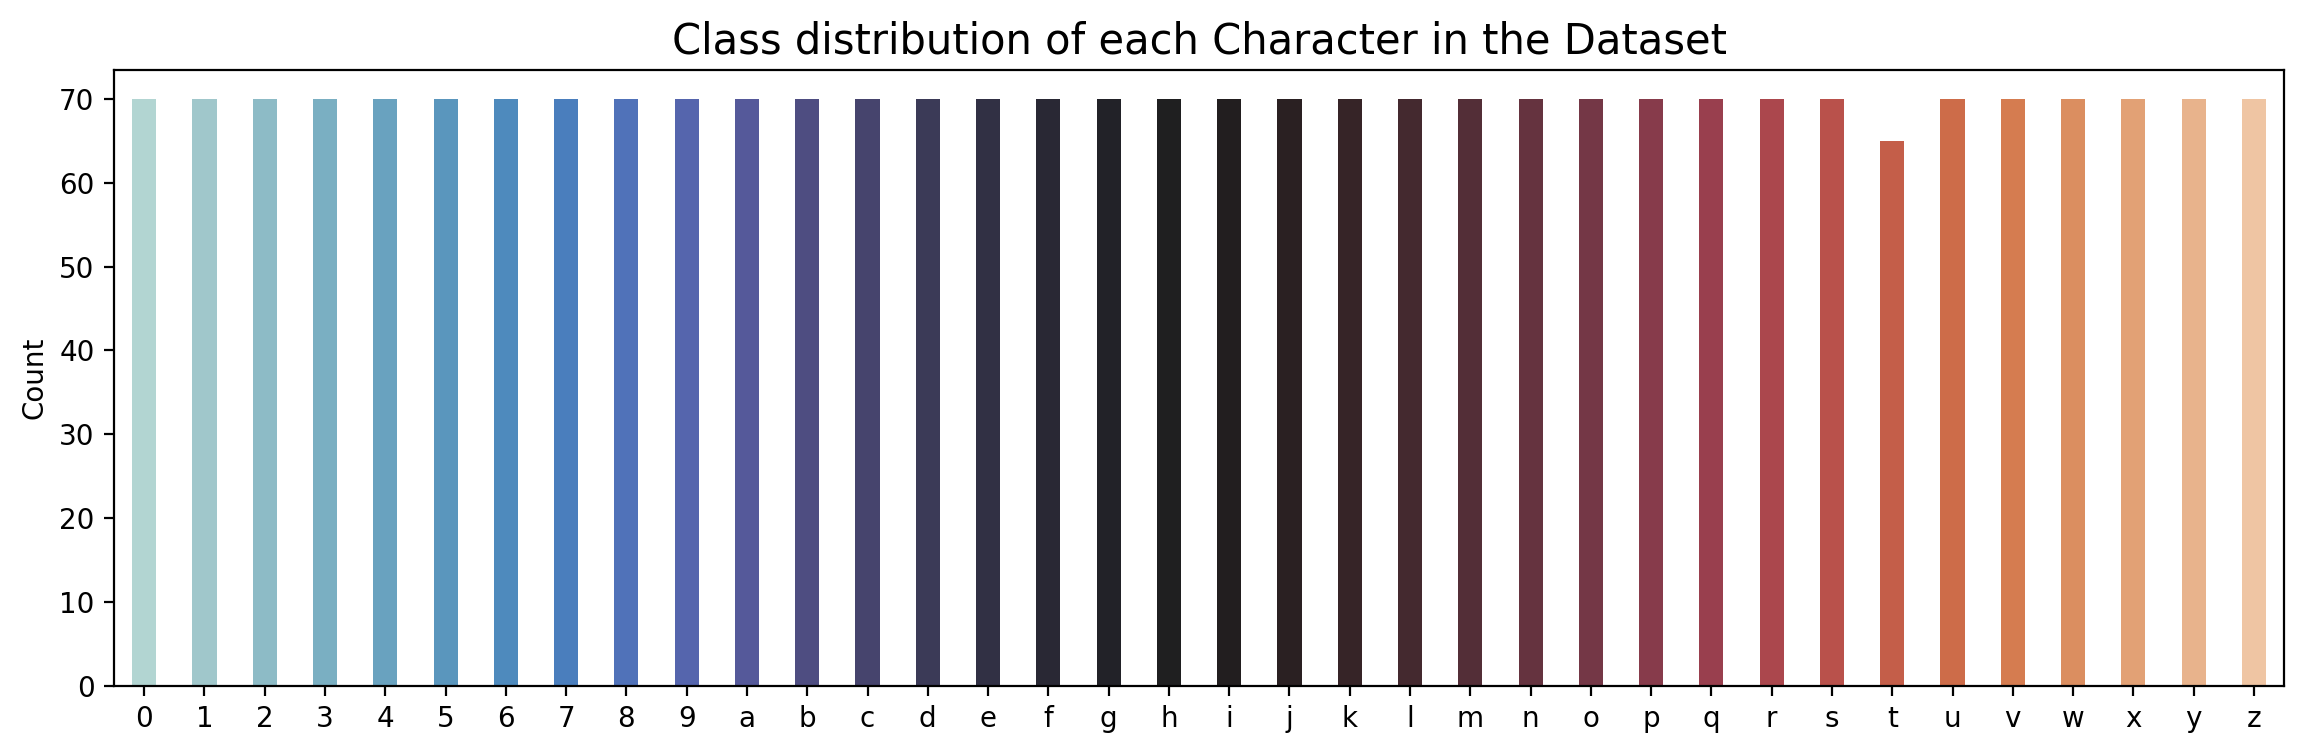

In [14]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution of each Character in the Dataset',fontsize=15)
plt.show()

## **Data Splitting: Splitting the Dataset into Train, Validation, and Test Data Sets**

In [15]:
import splitfolders

source_path = "/content/asl-dataset"
output_path = "/content/asl-dataset-split"
splitfolders.ratio(source_path, output_path, seed=1333, ratio=(0.8, 0.1, 0.1))

Copying files: 2515 files [00:00, 6454.54 files/s]


In [16]:
import shutil

shutil.rmtree("/content/asl-dataset-split/train/asl_dataset")
shutil.rmtree("/content/asl-dataset-split/val/asl_dataset")
shutil.rmtree("/content/asl-dataset-split/test/asl_dataset")

## **Data Augmentation: Creating Image Data Generators**

In [17]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [18]:
train_path = '/content/asl-dataset-split/train'
val_path = '/content/asl-dataset-split/val'
test_path = '/content/asl-dataset-split/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

In [19]:
train_data = datagen.flow_from_directory(directory= train_path, target_size=(image_size,image_size), batch_size = batch, class_mode='categorical')
val_data = datagen.flow_from_directory(directory= val_path, target_size=(image_size,image_size), batch_size = batch, class_mode='categorical')
test_data = datagen.flow_from_directory(directory= test_path,target_size=(image_size,image_size), batch_size = batch, class_mode='categorical', shuffle= False)

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


## **Building a Convolutional Neural Network (CNN) Model**

In [20]:
model = Sequential()

# Input Layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

# Fully Connected Layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(36, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

In [21]:
early_stoping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [22]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [23]:
asl_class = model.fit(train_data,
                      validation_data= val_data,
                      epochs=10,
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/10
63/63 [==============================] - 620s 10s/step - loss: 2.4561 - accuracy: 0.3211 - val_loss: 0.5525 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 602s 10s/step - loss: 0.6615 - accuracy: 0.8052 - val_loss: 0.2605 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 601s 10s/step - loss: 0.3602 - accuracy: 0.8887 - val_loss: 0.1867 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 605s 10s/step - loss: 0.2317 - accuracy: 0.9279 - val_loss: 0.1133 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 610s 10s/step - loss: 0.1510 - accuracy: 0.9498 - val_loss: 0.1239 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 597s 9s/step - loss: 0.1193 - accuracy: 0.9583 - val_loss: 0.1048 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - ETA: 0s - loss: 0.1

## **Evaluating the Model on Training, Validation, and Test Sets**

In [24]:
# Evaluvate for training generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The Accuracy of the model for Training data is:',acc*100)
print('The Loss of the model for Training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('\nThe Accuracy of the model for Validation data is:',acc*100)
print('The Loss of the model for Validation data is:',loss)

The Accuracy of the model for Training data is: 99.9502956867218
The Loss of the model for Training data is: 0.002870845142751932

The Accuracy of the model for Validation data is: 97.60956168174744
The Loss of the model for Validation data is: 0.09026971459388733


## **Data Visualization: Plots for Accuracy and Loss with epochs**

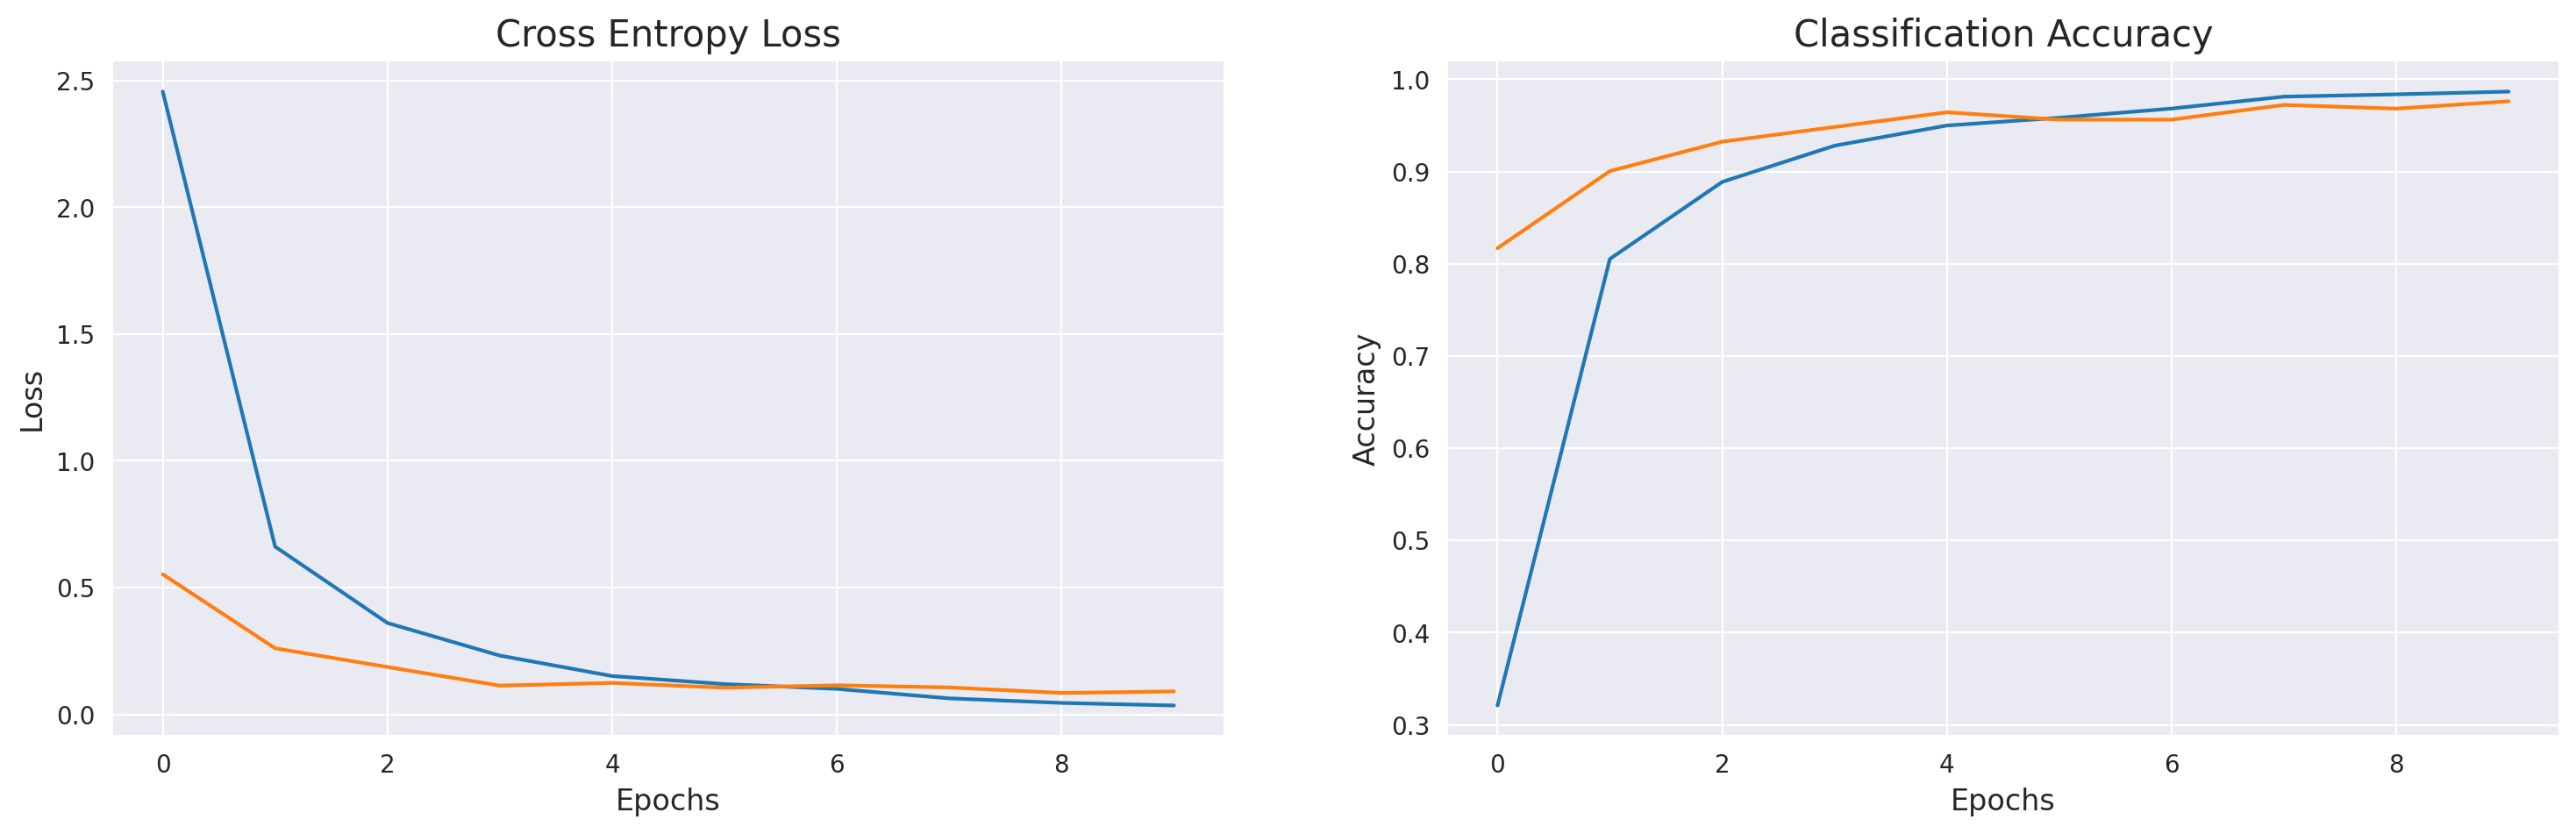

In [25]:
error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

## **Making Prediction on Testing Data**

In [26]:
result = model.predict(test_data,verbose = 0)
y_pred = np.argmax(result, axis = 1)
y_true = test_data.labels

## **Evaluvating the prediction made by the Model**

In [27]:
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 94.44444179534912
The Loss of the model for testing data is: 0.27976587414741516


In [28]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 238
Incorrect predicted classes: 14


## **Generating a Classification Report**
Provides detailed precision, recall, and F1-score metrics for each class.

In [29]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.88      1.00      0.93         7
           2       0.86      0.86      0.86         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      0.86      0.92         7
           c       1.00      1.00      1.00         7
           d       0.88      1.00      0.93         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      0.86      0.92         7
           h       1.00    